# CCN 2023 Tutorial
## Cognitive models of Behavior: Classical and Deep Learning Approaches

By Maria Eckstein, Kevin Miller, Kim Stachenfeld

https://colab.research.google.com/drive/1HMsETdAFzJ2yQou2m-qJZzDlpfxgcrO8?usp=sharing

# Getting started
To execute a "cell", you'll press Shift-Enter.

### Hosted Colab
If you're working from a hosted colab (recommended):
1. File > Save a copy in Drive
2. Connect (top right) > Connect to a hosted runtime (GPU)

### Run locally as a Jupyter Notebook

You can also open the notebook in jupyter notebook or a locally hosted colab. To run locally, you can open a terminal window and download the code with:

```
git clone https://github.com/kstach01/CogModelingRNNsTutorial
```

### Jupyter notebook

To run as a jupyter notebook, you can in the terminal window run the following. Note that much of the formatting will be lost in Jupyter Notebook.

```
pip install notebook
git clone https://github.com/kstach01/CogModelingRNNsTutorial
cd CogModelingRNNsTutorial
jupyter notebook CCN2023_CogModelingRNNsTutorial2023.ipynb
```


### Local colab kernel

To run locally from colab, you can follow the steps above to install jupyter notebook, then run the following:

```
  jupyter notebook \
    --NotebookApp.allow_origin='https://colab.research.google.com' \
    --port=8888 \
    --NotebookApp.port_retries=0
```
This will generate text including a link which will be what you connect the colab to.

You can then go to [https://research.google.com/colaboratory/](https://research.google.com/colaboratory/) and open CCN2023_CogModelingRNNsTutorial2023.ipynb.

To connect to the kernel, go to the down arrow in the top right corner > "Connect to local runtime" and then copy in the link generated by the command.

# Hints

**Need help?** To view information about a function or class, type `?` before the name of the function or class (For example, `?print` or `?str` will cause information about the print function or the string datatype to pop up on the right.)

**Table of Contents:** To view the Table of contents for the tutorial, you can click the icon in the top left with three dots next to three lines.

# Resources

**Code:** Additional code used by the tutorial can be found at [github.com/kstach01/CogModelingRNNsTutorial](https://github.com/kstach01/CogModelingRNNsTutorial). You are welcome to peruse it; however, it is not required to understand the tutorial.

# Introduction & Overview

In this Colab, you will learn how to implement and work with some of today's models.

* **Part 1: We will fit a Reinforcement Learning (RL) model to rat dataset.** We will learn *how to fit a computational model* (e.g., what is a negative log likelihood?). And we will see *what we can learn from an RL model* (e.g., interpreting values and learning rates). We will also see what we *can't* learn from this model (think interpretability versus predictive power).

* **Part 2: We will fit a recurrent neural network (GRU) to the same dataset.** We will learn how to set up and train a neural network on a dataset (spoiler: not that hard). We will see how it solves some of the problems we encountered when working with the classic RL model (think predictive power). And we will also see that we now encounter new problems (think interpretability).

* **Part 3: We will talk about two methods that combine the strengths of the classical and the neural network approach.** There are *many* ways to solve this conundrum. We will talk about two specific ones:
  * *Disentangled RNNs*, which produce interpretable models of behavior by forcing a neural network to disentangle its representation.
  * *Hybrid RNNs*, which test specific asssumptions of RL in a fully data-driven way, using neural networks.

* **Part 4: We will repeat Parts 1-3 with a "Mystery Agent" and see if we can uncover its mechanisms.** In Part 1, we are using fitting a 2-parameter Q-agent model to behavior generated by a 2-parameter Q-agent -- no surprise if we can fit that! Now we will explore using a "mystery agent" whose mechanism is unknown and is not an exact match for the RL model.

* **Part 5 (stretch): We will repeat Parts 1-3 with a Real World Dataset consisting of rats performing a 2-armed bandit task (Miller et al 2018).** We will see how different model classes shed light on the learning behavior of real rats.

***Let's get started!***

# Imports

Go ahead and run the two cells below to install and load the required packages.

In [103]:
#@title Install required packages.
try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

if _ON_COLAB:
  !rm -rf CogModelingRNNsTutorial
  !git clone https://github.com/kstach01/CogModelingRNNsTutorial
  !pip install -e CogModelingRNNsTutorial/CogModelingRNNsTutorial
  !cp CogModelingRNNsTutorial/CogModelingRNNsTutorial/*py CogModelingRNNsTutorial
else:
  !pip install CogModelingRNNsTutorial/requirements.txt

Cloning into 'CogModelingRNNsTutorial'...
remote: Enumerating objects: 827, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 827 (delta 210), reused 324 (delta 163), pack-reused 450
Receiving objects: 100% (827/827), 3.23 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Obtaining file:///content/CogModelingRNNsTutorial/CogModelingRNNsTutorial
  Preparing metadata (setup.py) ... done
  Running setup.py develop for CogModelingRNNsTutorial


In [104]:
#@title Imports + defaults settings.
%load_ext autoreload
%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings

warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

from CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial import rnn_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 0: Reinforcement Learning (RL)

In this section, you will get experience defining an RL agent and a simple two-armed bandit environment. The exercises in this section are intended to provide an intuition for the structure of the environment and how the agent works.

First, we want to get an intuition for the types of agents and environments that we will be working with. This builds on code (in the `bandits.py` file on
[github](https://github.com/kstach01/CogModelingRNNsTutorial), in case you are curious -- you should not need to access the code directly to do these exercises). The code in `bandits.py` implements RL agents (called `AgentQ`) and 2-armed bandit task environment (called `EnvironmentBanditsDrift`).

Below we will define an instance of agent and environment, respectively.

Execute the cell below to do all of this.

<a name="rl-in-a-nutshell"></a>
## RL in a nutshell

The environment in this task is a 2-armed drifting bandit, meaning that there are two available actions that each elicit stochastic rewards, and the probability of the reward drifts gradually over time.

An RL agent learns "Q-values" for each action (aka the expected reward of each action) in order to decide what choices to make. When the agent receives a reward for an action it chose, it will increment the Q-value of this action; when it does not receive a reward for its action, it will decrease the corresponding action value.

Repeating this process over and over, the agent's Q-values will get closer and closer to the actual reward probabilities. This means that the agent will be able to choose actions well, and therefore maximize rewards.


We'll see what this looks like for a single trial. First, we'll define an agent in the cell below. Then, we'll see how Q-values are modified after a single trial containing one choice and one reward outcome.

**Deep Dive: Q-values**

Remember that in RL, we always calculate reward prediction errors $\delta$:

$$\delta_t = r_t - Q_t(a_t)$$

In other words, we see how much reward $r$ we obtained on trial $t$ to get $r_t$. Then we check what the value $Q$ is of the action $a$ we chose on trial $t$ to get $Q_t(a_t)$. This entity $Q_t(a_t)$ is our "reward prediction".

Now, all that's left is to look at the difference between $Q_t(a_t)$ (our reward prediction) and the actual reward $r_t$, to obtain our "reward prediction error" $\delta_t$.

With the reward prediction error $\delta$, we can update our value $Q_t(a_t)$ to obtain $Q_{t+1}(a_t)$:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha * \delta_t$$

For the update, we *could* simply add the reward prediction error $\delta_t$ to our old value estimate $Q_t$, to immediately arrive at $r_t$, the true outcome. However, we don't really want to move *all the way* from the old value $V_t$ to the actual outcome $r_t$. We only want to move *a little bit*, in order to keep around some of the things we have already learned in the past.

This is the reason why we first multiply $\delta_t$ by $\alpha$, the *learning rate*, before we add it to $Q_t(a_t)$. (The learning rate $\alpha$ is a number between 0 and 1 that "scales" the reward prediction error. For example, if $\alpha=0.25$, we move a quarter of the way from $Q_t$ to $r_t$.)

In [3]:
#@title Define an agent and an environment
gen_alpha = 0.25  #@param
gen_beta = 5
n_actions = 2

environment = bandits.EnvironmentBanditsDrift(sigma=0.1, n_actions=n_actions)
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

# For later: if you would like to check out a different environment, uncomment the lines below.
# environment = bandits.EnvironmentBanditsFlips(
#     block_flip_prob=0.02, reward_prob_high=0.8, reward_prob_low=0.2)

# For later: if you would like to check out a different agent, uncomment the lines below.
# agent = bandits.MysteryAgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

In [4]:
#@title Agent behavior: **One trial.**
agent.new_sess()
print("Agent's initial Q-values:", agent.q)
# print("Environment's Reward Probabilities:", environment.reward_probs)
choice = agent.get_choice()
print("Agent's choice", choice)
reward = environment.step(choice)
print("Reward provided by the environment: ", reward)
agent.update(choice=choice, reward=reward)
print("Agent's new Q-values:", agent.q)

Agent's initial Q-values: [0.5 0.5]
Agent's choice 0
Reward provided by the environment:  True
Agent's new Q-values: [0.625 0.5  ]


**Question:** How did the Q-values change as a result of this outcome? What happened to the chosen action? What happened to the unchosen action?

**Exercise:** Execute the cell a few times to see what happens when the agent makes different choices and when it observes different outcomes.


Now, let's see how the agent performs on the task, doing 200 trials in a row on the environment we specified. Execute the cells below to run the agent through the loop.

**Questions:**
* What do the orange and blue line represent?
* What do the vertical green and red ticks represent?
* What is the relationship between the orange/blue and red/green lines


In [5]:
#@title Agent behavior: **One session**

n_trials = 200  #@param
choices = np.zeros(n_trials)
rewards = np.zeros(n_trials)
qs = np.zeros((n_trials, n_actions))
reward_probs = np.zeros((n_trials, n_actions))

# For each trial: Step the agent, step the environment, record everything
for trial_i in np.arange(n_trials):
  # Record environment reward probs and agent Qs
  reward_probs[trial_i, :] = environment.reward_probs
  qs[trial_i, :] = agent.q
  # First, agent makes a choice
  choice = agent.get_choice()
  # Then, environment computes a reward
  reward = environment.step(choice)
  # Finally, agent learns
  agent.update(choice, reward)
  # Log choice and reward
  choices[trial_i] = choice
  rewards[trial_i] = reward

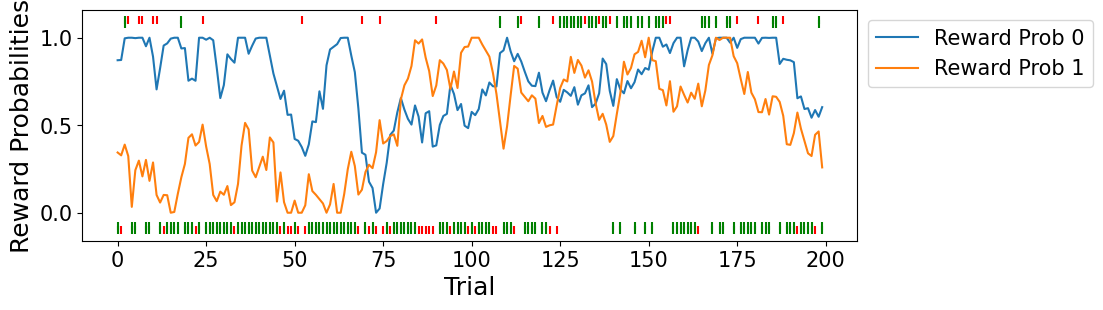

In [6]:
#@title Plot task structure and agent behavior.
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=reward_probs,
    timeseries_name='Reward Probabilities',
    labels=[f'Reward Prob {a}' for a in range(n_actions)])


Let's understand how the agent made the choices it made - let's look under the hood. Execute the cell below and answer the following

**Questions:**
* What do the orange and blue line represent? (Spoiler: It's different from before)
* What happens to the orange line when there's a green tick on the top of the figure? What happens when there's a red tick on the top? What happens to the orange line when there are ticks on the bottom side?
* How do you explain the movements of the lines? (Hint: This is RL in action! Look back at [RL in a nutshell](#rl-in-a-nutshell))
* How are Q-values and actions related? In other words, how do the orange and blue lines in this figure compare to the orange and blue lines above?

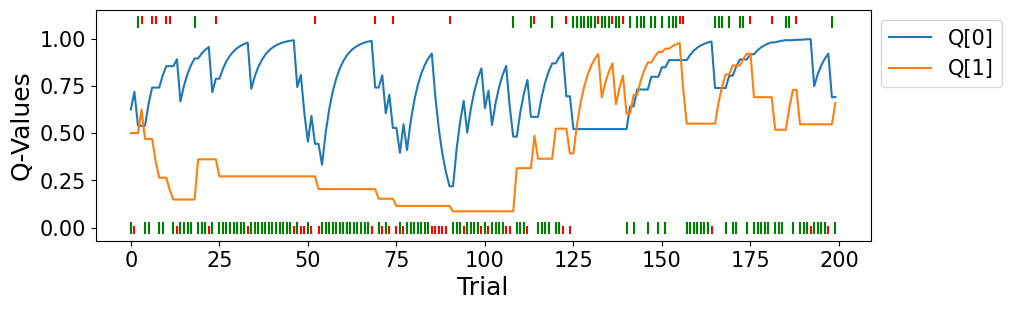

In [7]:
#@title Plot agent Q-values
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=qs,
    timeseries_name='Q-Values',
    labels=[f'Q[{a}]' for a in range(n_actions)])

Now that we know what Q-values are, how a Q-learning agent works, and how it behaves, let's run a whole bunch of them. (This might take a few seconds.)

In [18]:
#@title Generate synthetic data: **Whole dataset**
n_trials_per_session = 200
n_sessions = 100
dataset_train_to_view, experiment_list_to_view = bandits.create_dataset(
    agent=agent, environment=environment,
    n_trials_per_session=n_trials_per_session, n_sessions=n_sessions)

# To sample the next element in a dataset.
x, y = next(dataset_train_to_view)
print(f'x.shape = {x.shape} \ny.shape = {y.shape}')

x.shape = (200, 100, 2) 
y.shape = (200, 100, 1)


## Run diagnostics.
In order to understand the behavior of the agent in a richer way, we can generate some plots describing aspects of its behavior.

Run the cell below to see if the agent's actions are temporally autocorrelated; that is, what fraction of the time the agents choice now are the same as its choice n steps ago.

**Exercise:** what other diagnostics might you like to see? Feel free to make some of your own plots!

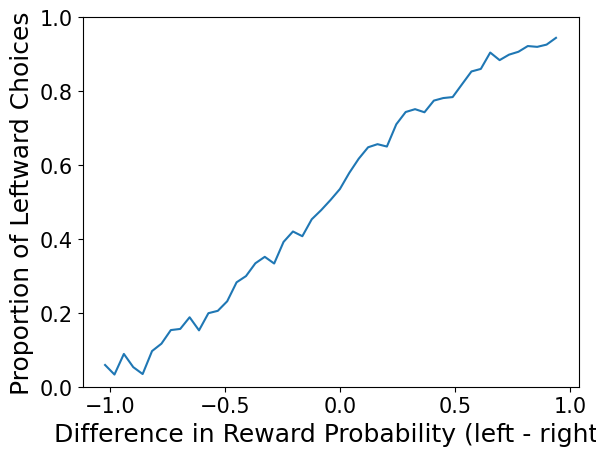

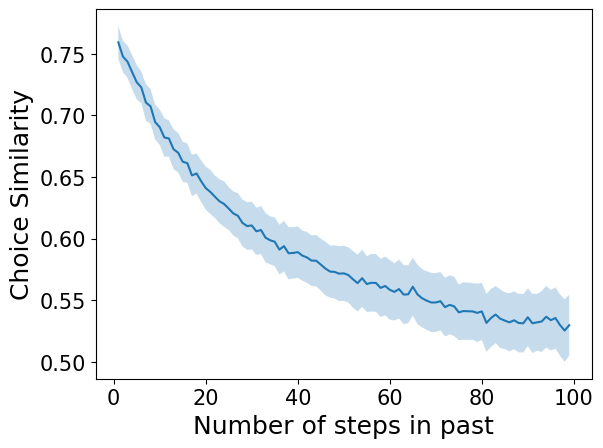

In [21]:
#@title Run some diagnostics to characterize the dataset
bandits.show_valuemetric(experiment_list_to_view)
plt.figure()
plotting.plot_action_similarity_to_history(experiment_list_to_view, n_steps_back=100)

**Exercise:** Experiment with different values of alpha and beta.

Go back to [the cell where we defined the agent](#define-agent-and-environment) and change the values of the `alpha` (note: `alpha` must be in the [0, 1] range) and `beta` parameter, then run all the cells until here. What changes in the behavior of the agent when you change `alpha`? What changes in the Q-values?

<a name="fit-classic-cognitive-model"></a>
# Part 1: Fit a Classic Cognitive Model

Now that we have an understanding of how our RL agent works, we will learn how to fit a cognitive model. In the following cell, select `dataset_type = SyntheticVanillaQ` from the dropdown menu on the right. (This will give us a dataset similar to the one above, where a Q-learning agent is performing a drifting 2-armed bandit task.) Select your preferred `alpha` (e.g., 0.25), `beta` (e.g., 5) parameters, and other parameters. Then run the cell.

In later exercises, we will substitute in different datasets by selecting different values for dataset_type from the dropdown menu below:
* `SyntheticMysteryQ` A more sophisticated "mystery agent", for which the cognitive model does not exactly match the agent
* `RealWorldRatDataset` real data from rats performing a bandit task with reversals. In order to access these, you'll first:
  1. Download any one data file from [https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing](https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing)
  2. When prompted to select a file to upload, select the file you've downloaded. The upload will take several seconds.

In [85]:
#@title Select dataset type.
#@markdown ## Select dataset:

dataset_type = 'RealWorldRatDataset'  #@param ['SyntheticVanillaQ', 'SyntheticMysteryQ', 'RealWorldRatDataset']
is_synthetic = dataset_type.startswith('Synthetic')


#@markdown Set up parameters for synthetic data generation:
if is_synthetic:
  gen_alpha = .25 #@param
  gen_beta = 5 #@param
  mystery_param = -2  #@param
  n_trials_per_session = 200  #@param
  n_sessions = 220  #@param
  sigma = .1  #@param
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma)

  # Set up agent.
  agent = {
      'SyntheticVanillaQ': bandits.VanillaAgentQ(gen_alpha, gen_beta),
      'SyntheticMysteryQ': bandits.MysteryAgentQ(gen_alpha, gen_beta, mystery_param=mystery_param),
      }[dataset_type]

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

#@markdown Set up parameters for loading rat data from Miller et al 2019.
elif dataset_type == 'RealWorldRatDataset':
  upload_new_data_file = "False" #@param ["True", "False"]
  upload_new_data_file = upload_new_data_file == "True"

  if not _ON_COLAB:
    LOCAL_PATH_TO_FILE = "<provide-filename-where-data-has-been downloaded>"  #@param
    if not os.path.exists(LOCAL_PATH_TO_FILE):
      raise ValueError('File not found.')
    FNAME_ = LOCAL_PATH_TO_FILE

  gen_alpha = "unknown"
  gen_beta = "unknown"
  sigma = 0.1  #@param
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma)


  if upload_new_data_file:
    url = "https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing"
    print(f'NOTE: Before you can upload a data file, you will need to download from from\n{url}\n\n Then you will select the file from the location where it has been downloaded and upload it to the colab.')
    uploaded = files.upload()
    FNAMES_ = list(uploaded.keys())
    FNAME_ = FNAMES_[0]
    if len(FNAMES_) > 1:
      print(f'\nWARNING: More than one file uploaded -- using only {FNAME_}.')

  else:
    if "FNAME_" not in list(locals().keys()):
      raise ValueError('No files found. Please change upload_new_data_file to True and upload a file.\nSee instructions above for more information.')

  dataset_train, dataset_test = rat_data.format_into_datasets(
      *rat_data.load_data_for_one_rat(FNAME_, '.')[:2], rnn_utils.DatasetRNN)
  n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
  experiment_list_train = None
  experiment_list_test = None

else:
  raise NotImplementedError(
      (f'dataset_type {dataset_type} not implemented. '
       'Please select from drop-down list.'))



Skipping experiment because None value was found for experiment_lists.
This is usually the case when using imported real data.


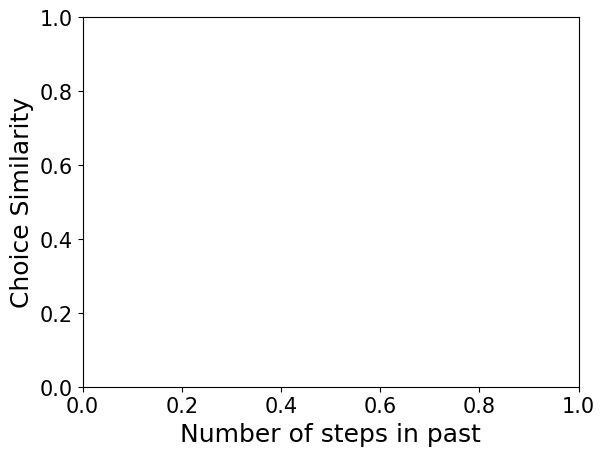

In [90]:
#@title Run some diagnostics to characterize the dataset
bandits.show_valuemetric(experiment_list_train)
plt.figure()
plotting.plot_action_similarity_to_history(experiment_list_train, n_steps_back=16)


## RL as a Model of Behavior

To see if subjects use RL, we "fit" the RL model to human behavior. This means that we "squeeze" and "stretch" the RL agent until it produces behavior that corresponds to the human behavior. In this case, the "squeezing" and "stretching" consists of increasing or decreasing the values of the *free parameters* of the model, learning rate $\alpha$ and inverse decision temperature $\beta$.

How do we know if we need to change the values of $\alpha$ and $\beta$? By checking how close the behavior of the model is to human behavior (i.e., how similar the model pancake is to the human pancake). The closer the model behavior matches human behavior, the better the model "fits" the human dataset, and the less we have to change the parameters.

On the other hand, the more different the model behavior is from human behavior, the more we have to still wiggle on $\alpha$ and $\beta$ to get it to match more closely. We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that maximize the similarity between human and model behavior. To do this, we will *maximizes the probability* that the RL agent chooses the same actions that humans have chosen.

**Saying the same thing but more "mathy", our goal is to find the values of our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed (human) behavior under the model.**

To do this, we will:
* Write a function that calculates the negative log likelihood (NLL)
* Set up an optimizer that will minimize the NLL
* The smallest NLL corresponds to the best parameters! The model is fitted.

The cell below provides a function that calculates the log likelihood for us. It takes a dataset (`dataset`, e.g., our syntheticly created behavior), a model (`model_fun`, e.g., our Q-learning agent), and model parameters (`params`, e.g., a learning rate `alpha` and an inverse decision temperature `beta`) as inputs.
It returns the normalized likelihood of the dataset under the model and the parameters as an output.

The likelihood of our dataset under the model is simply the probability each choice we see in the dataset would have occurred in the model:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150} p(a_{st})$$
This is the probability of each action at each trial $t$, for each subject $s$, which our model (aka RL agent) produces.

Because this is hard to calculate (numbers will get very small with so many multiplications), we take a trick: We take the log and add instead:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150}p(a_{st}) = \sum_{s=0}^{100} \sum_{t=0}^{150} log(p(a_{st}))$$

And because we don't want the number of trials (150) and subjects (100) to influence our results, we often normalize the log-likelihood:
$$p(dataset) \propto \sum_{s=0}^{n_s} \sum_{t=0}^{n_t} log(p(a_{st})) \ / \ n_s \ / \ n_t$$

In [91]:
#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

Let's see if this all makes sense. Answer the following questions:

* Which values of `alpha` and `beta` should give us the **highest** likelihood for the current dataset? Why is that?  
* Which values should give us very **low** likelihoods?

Now let's see if we were right. Use the cell below to calculate the likelihoods for some different values of `alpha` and `beta`. Type the values into the interface on the right, and execute the cell to calculate the likelihood. Try a few different combinations to see if your intuition was right!

In [92]:
#@title Calculate the log likelihoods for example parameters
test_alpha = 0.3 #@param
test_beta = 2 #@param

def inverse_sigmoid(x):
  return np.log(x/(1-x))

print('Calculating the log likelihood for alpha = {} and beta = {}.'.format(test_alpha, test_beta))
params = {'hk_agent_q': {'alpha_unsigmoid': inverse_sigmoid(jnp.array([test_alpha])), 'beta': jnp.array([test_beta])}}
_ = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)

Calculating the log likelihood for alpha = 0.3 and beta = 2.
Normalized Likelihood: 61.7%



If we were to calculate the LL for each combination of $\alpha \in [0, 1]$ and $\beta \in [0, 30]$, this is what we would get for data generated with `gen_alpha=0.75` and `gen_beta=5`. (The red cross marks the smallest NLL, aka best parameter combination):

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/NllGrid.png?raw=1" width=700></center>

We now have everything in place to fit our model! We have a function that calculates the LL for a model (e.g., Q-learning) and some parameters (e.g., `alpha` and `beta`), on any dataset. All that's left is find the largest possible LL, and we'll have the optimal parameters! (To do this, we usually find the *smallest* possible *negative* LL or NLL. But the logic is the same.)

Congrats on making it until here---this is model fitting in a nutshell!

The next cell does just that: It takes an agent (our Q-learnner) and a dataset (the synthetic one we made above), and finds the parameters with the best LL.

In [93]:
#@title Fit parameters
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=100,
    n_steps_max=1000)

Step 100 of 100; Loss: 1.3391e+04. (Time: 1.3s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 100 of 100; Loss: 1.3391e+04. (Time: 1.3s)
Model Converged! Time elapsed = 5e-05s.


While the cell is running, answer the following questions:

* Which parameters do you expect the function to return? I.e., what will the value be of `alpha`? And will the value be of `beta`? Why?
* Would the result be different for a different dataset? Why?

Now let's see! Execute the cell below to see what parameters we have fitted.

In [94]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]

print('Generative beta was: ', gen_beta)
print('Recovered beta was: ', fit_beta)
print('Generative alpha was: ', gen_alpha)
print('Recovered alpha was: ', fit_alpha)

Generative beta was:  unknown
Recovered beta was:  4.017501
Generative alpha was:  unknown
Recovered alpha was:  0.54411477


**Questions:**
* How does this model do in terms of interpretability? (A good way to think about his might be to think about the variables in the model: `alpha`, `beta`, Q-values. What does it mean that the model is build on these variables? How could we use them in a cognitive neurscience study?)
* How does this model do in terms of predictive power? (You can make a guess here - keep the question in mind until we have also fitted the neural network model in the next section.)

## Qualitative Model Fit

Now we will visually compare the performance of the RL agent that generated the dataset with the RL agent fit to that data, and see if they appear qualitatively similar. First, we will generate synthetic data from the agent with the fit model parameters. Then we can compare both side-by-side. If you coded up any of your own visualizations in Part 0, feel free to try them here!



In [95]:
#@title Synthesize a dataset using the fitted agent
rl_agent = bandits.AgentNetwork(bandits.HkAgentQ, rl_params)
_, experiment_list_rl = bandits.create_dataset(rl_agent, environment, n_trials_per_session, n_sessions)

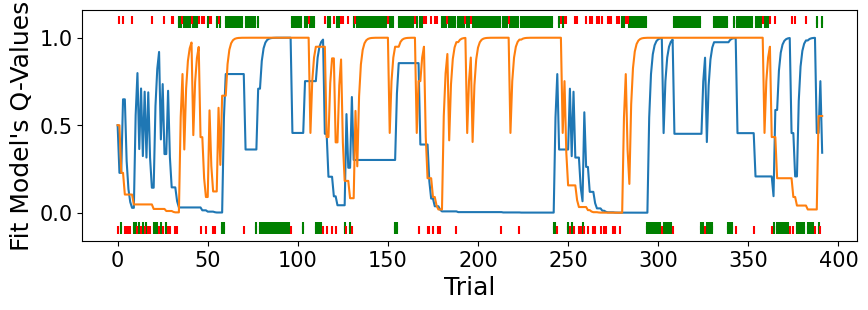

In [96]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session
xs, ys = next(dataset_train)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values")

Skipping experiment because None value was found for experiment_lists.
This is usually the case when using imported real data.
Skipping showing reward rate for Non experiment_list
Skipping experiment because None value was found for experiment_lists.
This is usually the case when using imported real data.
Skipping showing reward rate for Non experiment_list
Total Reward Rate is: 60.060%


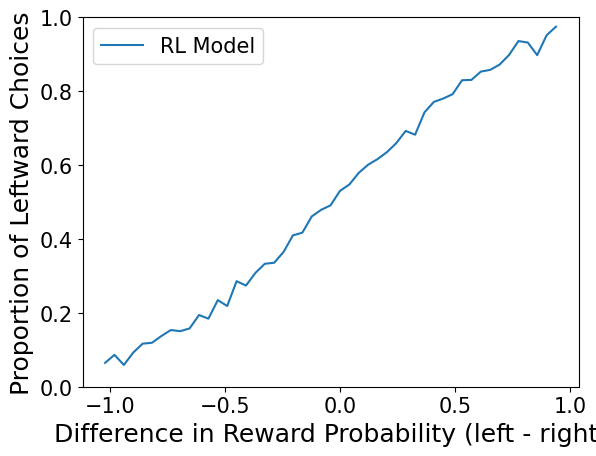

In [105]:
#@title Plot behavior diagnostics for each model.
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)
plt.legend()

**Questions:**
* How do the models compare visually?
* Do the different diagnostics tell us different things?

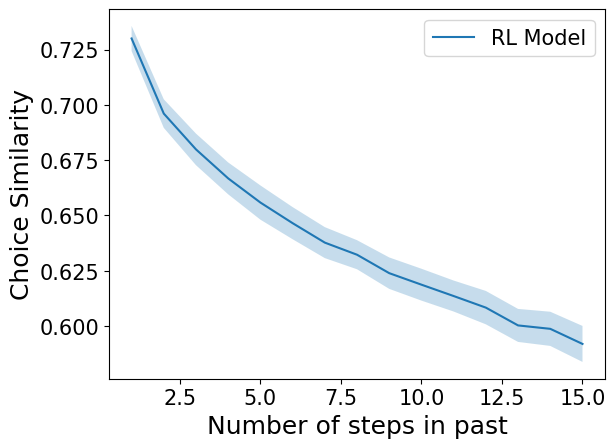

In [106]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model'])

## Quantitative Model Fit

Oftentimes, we want to know the "quality of fit" of a model. This is the case when we fit several models (as we will do shortly), and want to know which one captures the dataset best.

A common choice to calculate model fit are measures such as AIC and BIC. However, these don't work well once we switch to neural networks. (The reason is that the AIC and BIC penalize models for their complexity, usually by counting "free parameters". But it is very hard to determine the model complexity of a neural network, or break it down to the number of free parameters.)

Another choice, which is more common in machine learning, is to calculate the fit on a "held-out" dataset - a dataset that the model has not seen during training, and hence does not know. The idea is that if the model is still able to predict the behavior in this new dataset, it captures the underlying patterns well. (This also solves a big problem when working with neural networks, called "overfitting": Because neural networks have so many free parameters and are so flexible, they can "overfit" to their training data - basically just memorizing it - without learning anything deeper about it. If that's the case, the model will fit very poorly to a held-out dataset.)

The good thing about calculating a model's quality of fit in terms of the held-out prediction is that it works for both classical models (like the Q-learning model we've used here), and for neural network models.

In [107]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, params)

Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 61.7%
Held-Out Dataset
Normalized Likelihood: 61.1%


**Questions:**
* What do you observe? Are the likelihoods the same or different? What does that indicate?

# Part 2: Fitting with RNNs

Now that we have seen what it is like to fit a classic cognitive model, let us see how we can fit a neural network to the data!

The logic will be very similar:
* We will set up the RNN model (in this case, we are using a model called Gated Recurent Units, or [GRUs](https://arxiv.org/abs/1406.1078). Just like the classic model, the RNN will choose actions in the 2-armed bandit task. It will make a choice, observe a reward, and then predict the probability of the subsequent choice. We will use this probability prediction to calculate our likelihood, just like we did above. Y
* Once we have the likelihood, we do the same we did above: We find the model parameters that maximize the likelihood, because these provide the best fit for the dataset. What is different here is the nature of the free parameters: Where we had `alpha` and `beta` above, here we have biases `b` and weights `W`.
* After fitting the model, we can again calculate the model fit, aka held-out likelihood. We will use the same training and testing dataset as we did before, so we will be able to directly compare how the predictions of this model compare to the predictions of the Q-learning model.

In [108]:
#@title Set up the RNN (GRU) Model
n_hidden = 16  #@param
def make_gru():
  model = hk.DeepRNN(
      [hk.GRU(n_hidden), hk.Linear(output_size=2)]
  )
  return model

In [ ]:
#@title Fit the RNN (GRU) model
#@markdown You can experiment with values, but n_steps_max = 5000 was used for testing.
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-2)
gru_params, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max)

Step 500 of 500; Loss: 8.4539e+03. (Time: 71.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 500 of 500; Loss: 8.2213e+03. (Time: 69.1s)
Model not yet converged (convergence_value = 0.02750968) - Running more steps of gradient descent. Time elapsed = 8e-05s.
Step 410 of 500; Loss: 7.9853e+03. (Time: 62.9s)

In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params)

**Questions**
* How does the log likelihood compare for the RNN compare to the RL model we fit?

Now that we have thought about model fit (predictive power), let's think about interpretability.
* Before you run the next cell, think about what it would mean for the model to be interpretable. In other words, how could we use the model to understand the cognitive better than agents were using in the dataset? (Hint: Remember what we did in the case of the Q-learning model: We could plot the values over time, and get a good sense of why it chose the actions it chose at which trials.)
* Now, execute the next cell. What does the plot show? What does this mean in terms of interpretability?

In [ ]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

**Questions:**
* To what extent are these activations "interpretable"? Is it even possible to tell from this figure?

Now, let's run this new model "open-loop": As in Part 1, we will use it to generate choices so we can analyze its behavior. Execute the next cell to create a dataset of GRU choices on the 2-armed bandit task.

In [ ]:
#@title Synthesize a dataset using the fit network
gru_agent = bandits.AgentNetwork(make_gru, gru_params)
_, experiment_list_gru = bandits.create_dataset(gru_agent, environment, n_trials_per_session, n_sessions)

Now, let's see how behavior compares to the behavior of the original dataset, looking at the same diagnostic plots.

In [ ]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

plt.legend()


In [ ]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU'])



**Questions:**
* How well do the different models we've looked at so far?
* How do they differ in terms of predictability and interpretability?

# Part 3: Fitting with "Interpretable" RNNs

## Disentangled RNNs
In this section, we will explore using "disentangled RNNs" ([Miller et al 2023](https://www.biorxiv.org/content/10.1101/2023.06.23.546250v1)) to learn a predictive model that is constrained to yield interpretable latent variables. The model fitting will proceed in the same fashion as in parts 1 + 2; however, now the model has additional structure that will encourage it to learn more interpretable models.

Training this model can take several minutes if you are not connected to a GPU kernel. If you are impatient to move on to Hybrid-RNNs, you can lower the number of steps for training (`n_steps`), but keep in mind this model's performance (and interpretability) will likely still be far from optimal.

In [ ]:
#@title Set up Disentangled RNN.
#@markdown Number of latent units in the model.
latent_size = 5  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=1e-2)

In [ ]:
#@title Fit disRNN with no penalty at first, to get good quality-of-fit
#@markdown You can experiment with different values, but colab has been tested with 1000.
print(('Warning: this step can be rather time consuming without GPU access. If you are not running on a GPU\n, '
       'you may want to set n_steps to a very low value and return to the exercise when you \n'
       'have access to hardware acceleration.'))
n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

In [37]:
#@title Now fit more steps with a penalty, to encourage it to find a simple solution
#@markdown You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

Step 1810 of 3000; Loss: 1.9217e+04. (Time: 599.4s)

KeyboardInterrupt: ignored

## Visualize model latents.
Here we will visualize the model update terms and the masking on each latent variable and input. We will also plot the activities of latent units in the model to see if they reveal anything about the learning mechanisms.  

In [72]:
#@title Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params)
disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)

NameError: ignored

In [73]:
#@title Plot example session: latents + choices.
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_disrnn_eval, disrnn_params, xs[:trial_end, sess_i:sess_i+1])
network_states = np.array(network_states)
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
disrnn_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=disrnn_activations,
                     timeseries_name='Network Activations')

NameError: ignored

In [ ]:
#@title Normalized likelihoods
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    dataset_test, make_disrnn_eval, disrnn_params)

### Qualitative fit.
Finally, we will revisit the behavioral diagnostics we explored at the beginning.

In [74]:
#@title Synthesize a dataset using the fit network
disrnn_agent = bandits.AgentNetwork(make_disrnn_eval, disrnn_params)

_, experiment_list_disrnn = bandits.create_dataset(
    disrnn_agent, environment, n_trials_per_session, n_sessions)

NameError: ignored

Total Reward Rate is: 61.523%
Total Reward Rate is: 61.507%
Total Reward Rate is: 59.984%
Total Reward Rate is: 59.414%


NameError: ignored

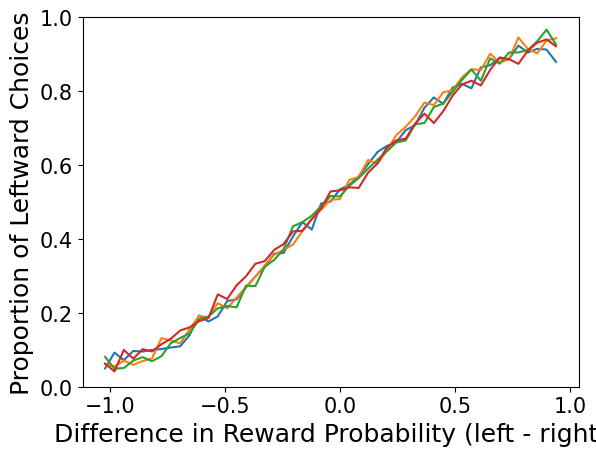

In [75]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

bandits.show_valuemetric(experiment_list_disrnn, label='Dis-RNN')
bandits.show_total_reward_rate(experiment_list_disrnn)

plt.legend()


In [76]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN'])



NameError: ignored

## Hybrid RNNs

In this section, we will explore a different approach to building interpretable models with RNNs: the hybrid-RNN approach from [Eckstein et al 2023](https://www.biorxiv.org/content/10.1101/2023.05.17.541226v1.abstract). The central idea is to replace components of RL models one-by-one with Neural Networks, thus using data to fit certain terms with potentially complex functions.

In [77]:
#@title Set up Hybrid RNN.

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_hidden_state = 'True'  #@param ['True', 'False']

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_previous_values = 'False'  #@param

#@markdown If True, learn a value for the forgetting term
fit_forget = "True"  #@param

#@markdown Learn a reward-independent term that depends on past choices.
habit_weight = 1  #@param [0, 1]

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': 16}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer = optax.adam(learning_rate=1e-2)

In [ ]:
#@title Fit the hybrid RNN
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset=dataset_train,
    optimizer=optimizer,
    loss_fun='categorical',
    convergence_thresh=1e-4,
    n_steps_max=5000,
)


### Quantitative + Qualitative Fit
Once again, we will synthesize a dataset from the fitted model and compare it quantitatively and qualitatively to the data.

In [ ]:
#@title Synthesize a dataset using the fitted network
hybrnn_agent = bandits.AgentNetwork(make_hybrnn, hybrnn_params, )
_, experiment_list_hybrnn = bandits.create_dataset(
    hybrnn_agent, environment, n_trials_per_session, n_sessions)

In [1]:
#@title Save out latent variables from the network.
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_hybrnn, hybrnn_params, xs)

h_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
v_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
h = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))
v = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))

for t in range(n_trials_per_session):
  for s in range(len(network_states)):
    h_state[t] = network_states[t][0]
    v_state[t] = network_states[t][1]
    h[t] = network_states[t][2]
    v[t] = network_states[t][3]

NameError: ignored

In [ ]:
#@title Plot latents and simulated behavior across session for Hybrid-RNN.
sess_i = 1
choices = xs[:, sess_i, 0]
rewards = xs[:, sess_i, 1]

hybrnn_values = v[:, sess_i, :]
hybrnn_v_state = v_state[:, sess_i, :]


bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_values,
                     timeseries_name='Hybrid RNN Values')




In [ ]:
#@title Plot Q-values.
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=qs, timeseries_name='Q-Values',
    labels=[f'Q[{a}]' for a in range(n_actions)])

**Question:** Above we plotted the Q-values. Can we do that for the GRU or the Disentangled RNN? What is required of models to enable this?

In [2]:
#@title Print Normalized Likelihoods for Hybrid RNN.
print('Normalized Likelihoods for Hybrid RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_hybrnn, hybrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_hybrnn, hybrnn_params)

Normalized Likelihoods for Hybrid RNN
Training Dataset


NameError: ignored

In [3]:
#@title Plot action similarities.
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    experiment_list_hybrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN', 'Hybrid RNN'],
    bbox_to_anchor=(1, 1))


NameError: ignored

# Part 3: Compare different datasets.

Return to Part 1 and select a different value for dataset_type: 'Synthetic_MysteryQ'. Repeat Parts 1 + 2.

How do the answers to your questions differ?

# Part 4: Work with real data

Congratulations, you have learned about a classic Q-learning agent, about model fitting, about neural networks, and about two new classes of hybrid models!

Now, let's see how we can apply this to a real dataset. Go back to [where we selected our dataset](#fit-classic-cognitive-model) and choose the rat dataset now!

Note: some parts of the visualizations will not work in the same way, since experiment_list_train and experiment_list_test are generated synthetically. What other metrics might you be interested in plotting?